In [8]:
# In this Notebook Feriados and Ventas datasets will be joined, transformed and utilised to make predictions

import warnings
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

warnings.filterwarnings("ignore")

In [9]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    timeseries = timeseries.iloc[:,0].values
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [10]:
path_to_ventas = r'data/cant_ventas_2014-2019.csv'
ventas_df = pd.read_csv(path_to_ventas)
# convert column fecha to datetime
ventas_df['fecha'] = ventas_df['fecha'].astype('datetime64[ns]')
ventas_df.set_index('fecha', inplace=True)
ventas_df.index

DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2019-03-18', '2019-03-19', '2019-03-20', '2019-03-21',
               '2019-03-22', '2019-03-23', '2019-03-24', '2019-03-25',
               '2019-03-26', '2019-03-27'],
              dtype='datetime64[ns]', name='fecha', length=1912, freq=None)

In [11]:
path_to_feriados = r"data/feriados.csv"
feriados_df = pd.read_csv(path_to_feriados, delimiter=';', parse_dates=True, dayfirst=True)
# convert column fecha to datetime enforcing dd/mm/yy format
feriados_df['Date'] = pd.to_datetime(feriados_df['Date'], format='%d/%m/%y')
# convert column to datetime to make it index
feriados_df['Date'] = feriados_df['Date'].astype('datetime64[ns]')
feriados_df.set_index('Date', inplace=True)
feriados_df.index

DatetimeIndex(['2012-01-01', '2012-03-01', '2012-04-05', '2012-04-06',
               '2012-04-08', '2012-05-01', '2012-05-15', '2012-06-12',
               '2012-08-15', '2012-09-29',
               ...
               '2022-04-14', '2022-04-15', '2022-04-17', '2022-05-01',
               '2022-05-15', '2022-06-12', '2022-08-15', '2022-09-29',
               '2022-12-08', '2022-12-25'],
              dtype='datetime64[ns]', name='Date', length=132, freq=None)

In [12]:
feriados_df.head()

,Year,Month,Day,Weekday,Holiday
Date,,,,,
2012-01-01,2012,1,1,Sunday,Anho Nuevo
2012-03-01,2012,3,1,Thursday,Dia de los Heroes de la Patria
2012-04-05,2012,4,5,Thursday,Jueves Santo (Semana Santa)
2012-04-06,2012,4,6,Friday,Viernes Santo (Semana Santa)
2012-04-08,2012,4,8,Sunday,Domingo de Resurreccion (Semana Santa)


### Transform ventas_df dataframe

In [13]:
# Replace NaN values 
ventas_df['cantidad'] = ventas_df['cantidad'].fillna(0)
ventas_df.head()

,linea,cantidad
fecha,,
2014-01-01,PRODUCTO A,7.0
2014-01-02,PRODUCTO A,57.0
2014-01-03,PRODUCTO A,67.0
2014-01-04,PRODUCTO A,17.0
2014-01-05,PRODUCTO A,6.0


In [14]:
##ventas_df.index = ventas_df.fecha
ventas_df = ventas_df.resample('D').mean()


In [15]:
# We gotta handle the zero values before applying log transformation
if len(ventas_df.loc[ventas_df['cantidad']==0]):
    print("Found records with zero, will add a constant (400)")
    ventas_df['cantidad'] = ventas_df['cantidad'] + 400

# Transform the dataframe:
ts_log = np.log(ventas_df)
# Replace infs with NaN
ts_log.replace([np.inf, -np.inf], np.nan, inplace=True)
# Replace NaN with 0
ts_log.replace([np.nan], 0, inplace=True)
# Remove all the NaN values
ts_log.dropna(inplace=True)

ts_log = ts_log.asfreq(freq='D')
ts_log.index

## Get all rows with nan values:
# ts_log[np.isnan(ts_log).any(1)]

## CHECK OUTPUT OF HEAD():
ts_log.head()

# 2014-01-01	6.008813
# 2014-01-02	6.124683
# 2014-01-03	6.146329

## Given that the differencing operation makes the values at the beginning of the series go NaN,
## we must make sure to store those values so that we can then get the real values back later on.
## In this case, something like: ts_log_diff.fillna(0) + 6.008813

# Apply differencing:
ts_log_diff = ts_log - ts_log.shift()


## Get indices with inf values:
# ts_log_diff.index[np.isinf(ts_log_diff).any(1)]
## Get all rows with inf values:
# ts_log_diff[np.isinf(ts_log_diff).any(1)]

ts_log_diff.replace([np.inf, -np.inf], np.nan, inplace=True)
ts_log_diff.dropna(inplace=True)

Found records with zero, will add a constant (400)


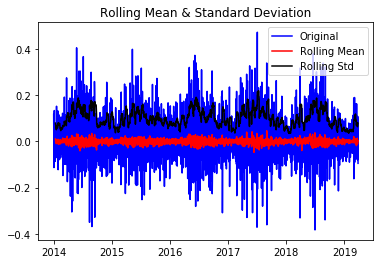

Results of Dickey-Fuller Test:
Test Statistic                -1.301966e+01
p-value                        2.468969e-24
#Lags Used                     2.600000e+01
Number of Observations Used    1.884000e+03
Critical Value (1%)           -3.433826e+00
Critical Value (5%)           -2.863075e+00
Critical Value (10%)          -2.567587e+00
dtype: float64


In [16]:
test_stationarity(ts_log_diff)

## Join the dataframes

In [17]:
data_df = ts_log_diff.join(feriados_df, how='left')

In [18]:
## data_df.iloc[:,0].values
# Replace NaN values 
data_df['cantidad'] = data_df['cantidad'].fillna(0)
# Check nulls: 
data_df.loc[data_df['cantidad'].isnull()]
# Check for other odd values: 
data_df[data_df['cantidad'].isin([np.nan, np.inf, -np.inf])]

,cantidad,Year,Month,Day,Weekday,Holiday


In [230]:
## Convertion to int would be an option if we weren't applying log transformation
# Convert 'cantidad' to int
# data_df['cantidad'] = data_df['cantidad'].astype('int64')

# Feature Engineering

In [19]:
# Add new columns:
# holiday_weekday
# holiday_weekend
# isweekday
# isweekend
# inbetween25and5

data_df['isweekday'] = [1 if d >= 0 and d <= 4 else 0 for d in data_df.index.dayofweek]
data_df['isweekend'] = [0 if d >= 0 and d <= 4 else 1 for d in data_df.index.dayofweek]
data_df['inbetween25and5'] = [1 if d >= 25 or d <= 5 else 0 for d in data_df.index.day]
data_df['holiday_weekend'] = [1 if (we == 1 and h not in [np.nan]) else 0 for we,h in data_df[['isweekend','Holiday']].values]
data_df['holiday_weekday'] = [1 if (wd == 1 and h not in [np.nan]) else 0 for wd,h in data_df[['isweekday','Holiday']].values]

# One-Hot Encoding of Holiday:
data_df = pd.get_dummies(data_df, columns=['Holiday'], prefix=['holiday'], dummy_na=True)


In [20]:
# Drop irrelevant columns:
data_df.drop(columns=['Year', 'Month', 'Day', 'Weekday', 'Holiday', 'linea'], inplace=True, errors='ignore')

In [21]:
data_df.head()

,cantidad,isweekday,isweekend,inbetween25and5,holiday_weekend,holiday_weekday,holiday_Anho Nuevo,holiday_Batalla de Boqueron,holiday_Dia de la Fundacion de Asuncion,holiday_Dia de la Independencia Nacional,holiday_Dia de la Paz del Chaco,holiday_Dia de la Virgen de Caacupe,holiday_Dia de los Heroes de la Patria,holiday_Dia de los Trabajadores,holiday_Domingo de Resurreccion (Semana Santa),holiday_Jueves Santo (Semana Santa),holiday_Navidad,holiday_Viernes Santo (Semana Santa),holiday_nan
2014-01-02,0.115870,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2014-01-03,0.021646,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2014-01-04,-0.113243,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2014-01-05,-0.026733,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2014-01-06,0.133531,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [22]:
# To set the frequency it's important not to have duplicated indices
if len(data_df[data_df.index.duplicated()].values):
    print("{} duplicated indices were found.".format(len(data_df[data_df.index.duplicated()].values)))
    data_df = data_df[~data_df.index.duplicated()]

# the following line will add a 'freq' to our datetime index
data_df = data_df.asfreq('D')
data_df.index

1 duplicated indices were found.


DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-04', '2014-01-05',
               '2014-01-06', '2014-01-07', '2014-01-08', '2014-01-09',
               '2014-01-10', '2014-01-11',
               ...
               '2019-03-18', '2019-03-19', '2019-03-20', '2019-03-21',
               '2019-03-22', '2019-03-23', '2019-03-24', '2019-03-25',
               '2019-03-26', '2019-03-27'],
              dtype='datetime64[ns]', length=1911, freq='D')

In [23]:

#data_df_daily = data_df
#data_df_daily.head()


In [24]:
# Function that trains the model with the received parameters
import statsmodels.api as sm
import itertools

def my_train_sarimax(df, i_order=(2,1,2), i_freq='D', i_seasonorder=(2, 1, 1, 12), print_summary=False):
    mod = sm.tsa.statespace.SARIMAX(
                                    df.iloc[:,0], # Variable to be predicted
                                    order= i_order,
                                    freq= i_freq 
                                    #,exog = ['isweekday', 'isweekend', 'inbetween25and5', 'holiday_weekend', 'holiday_weekday', 'holiday_Anho Nuevo',       'holiday_Batalla de Boqueron',       'holiday_Dia de la Fundacion de Asuncion',       'holiday_Dia de la Independencia Nacional',       'holiday_Dia de la Paz del Chaco',       'holiday_Dia de la Virgen de Caacupe',       'holiday_Dia de los Heroes de la Patria',       'holiday_Dia de los Trabajadores',       'holiday_Domingo de Resurreccion (Semana Santa)',       'holiday_Jueves Santo (Semana Santa)', 'holiday_Navidad',       'holiday_Viernes Santo (Semana Santa)', 'holiday_nan']
                                    ,exog = df.iloc[:,1:] # exogenous variables
                                    ,seasonal_order=i_seasonorder,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False
                                   )

    results = mod.fit()
    
    if print_summary:
        print(results.summary().tables[1])
    
    return results

# Function that compares SARIMAX predictions vs Real values
# SARIMAX documentation: https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
def compare_pred_vs_real(results, df, predict_from = '2019-03-01', exog_validation = ''):
    # se puede usar el parámetro end para especificar el limite de la predicción
    pred = results.get_prediction(start=pd.to_datetime(predict_from), end=pd.to_datetime('2019-03-27'), dynamic=False, exog=exog_validation)
    pred_ci = pred.conf_int()

    ax = df['2019':].iloc[:,0].plot(label='Observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Cant prod vendidos')
    plt.legend()

    plt.show()
    
    y_forecasted = pred.predicted_mean
    y_truth = df[predict_from:].iloc[:,0]

    mse = ((y_forecasted - y_truth) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

    print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
    
    return y_truth, y_forecasted
    
    
# Function for parameter tuning
def find_optimal_params(df, i_freq='D', verbose=False):
    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    min_aic = 99999999999.0
    opt_params = {'order':'', 'seasonal_order':''}
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(df.iloc[:,0],\
                                                order=param,\
                                                freq=i_freq
                                                ,exog=df.iloc[:,1:]
                                                ,seasonal_order=param_seasonal,\
                                                enforce_stationarity=False,\
                                                enforce_invertibility=False)

                results = mod.fit()
                if verbose:
                    print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
                    
                if results.aic < min_aic:
                    min_aic = results.aic
                    opt_params['order'] = param
                    opt_params['seasonal_order'] = param_seasonal
            except:
                print("error while fitting model")
                continue
    print('Min_AIC')
    print(opt_params)

# Predict using Daily frequency

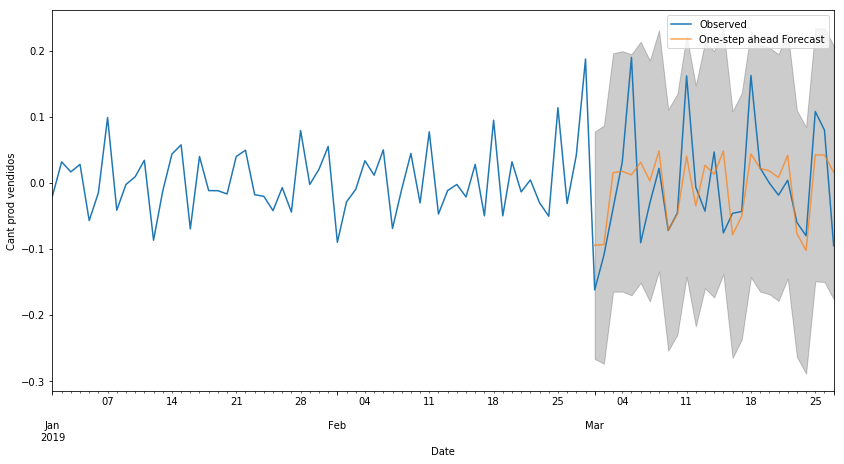

2019-03-01   -0.067513
2019-03-02   -0.016143
2019-03-03   -0.054164
2019-03-04    0.013827
2019-03-05    0.177558
2019-03-06   -0.121628
2019-03-07   -0.033536
2019-03-08   -0.026602
2019-03-09   -0.000441
2019-03-10    0.001876
2019-03-11    0.121316
2019-03-12    0.028464
2019-03-13   -0.069444
2019-03-14    0.033658
2019-03-15   -0.123821
2019-03-16    0.032384
2019-03-17    0.007215
2019-03-18    0.118744
2019-03-19    0.000596
2019-03-20   -0.018251
2019-03-21   -0.026579
2019-03-22   -0.037792
2019-03-23    0.016909
2019-03-24    0.022156
2019-03-25    0.065543
2019-03-26    0.037764
2019-03-27   -0.110932
Freq: D, dtype: float64

The Mean Squared Error of our forecasts is 0.0
The Root Mean Squared Error of our forecasts is 0.07


In [25]:
result_daily = my_train_sarimax(data_df[:'2019-02-28'], i_order=(2,1,2), i_freq='D', i_seasonorder=(2, 1, 1, 12))
ypred, ytruth = compare_pred_vs_real(result_daily, data_df, '2019-03-01', exog_validation=data_df['2019-03-01':].iloc[:,1:])
#ypred.astype(np.int64) - ytruth.astype(np.int64)
ypred - ytruth

In [26]:
#ypred.head() ## desde 2019-03-01
#ytruth.head() ## desde 2019-03-01
#data_df.head() ## desde 2014-01-02


In [27]:

## NOW YOU WILL HAVE TO append to y_pred all the dates that are missing (from data_df)
## but before doing that, you will have to add the missing dates to data_df (in our case the 1st of jan, 2014)
## After doing all that we can revert the differencing with cumsum() and then apply exp() to revert the log transform.


#create a series with the dates that were dropped with differencing
restore_first_values = pd.Series([6.008813], index=[pd.to_datetime('2014-01-01')])
#get the values that the prediction does not have
missing_part = data_df['cantidad'][:'2019-02-28']
rebuilt = restore_first_values.append(missing_part).append(ypred)

#revert the differencing:
rebuilt = rebuilt.cumsum()

#revert log transformation:
rebuilt = np.exp(rebuilt).round() # apply round() to have integers


In [28]:
## check how far was the prediction from the actual value

rebuilt['2019-03-01':] - ventas_df['cantidad']['2019-03-01':]

2019-03-01    0.0
2019-03-02    0.0
2019-03-03    0.0
2019-03-04    0.0
2019-03-05    0.0
2019-03-06    0.0
2019-03-07    0.0
2019-03-08    0.0
2019-03-09    0.0
2019-03-10    0.0
2019-03-11    0.0
2019-03-12    0.0
2019-03-13    0.0
2019-03-14    0.0
2019-03-15    0.0
2019-03-16    0.0
2019-03-17    0.0
2019-03-18    0.0
2019-03-19    0.0
2019-03-20    0.0
2019-03-21    0.0
2019-03-22    0.0
2019-03-23    0.0
2019-03-24    0.0
2019-03-25    0.0
2019-03-26    0.0
2019-03-27    0.0
dtype: float64

# Parameter Tuning

In [29]:
find_optimal_params(data_df_weekly, 'W')

# Min_AIC
# {'seasonal_order': (0, 2, 2, 12), 'order': (0, 1, 1)}

## Note: Using these parameters did not result in more accurate predictions for a small window of time. 
##     Further experimentation is required to see if at a larger time window these parameters will be better.

In [30]:
#run predictions with optimal parameter for weekly dataset
result_weekly_opt = my_train_sarimax(data_df_weekly, i_order=(0,1,1), i_freq='W', i_seasonorder=(0, 2, 2, 12))
ytruth, ypred = compare_pred_vs_real(result_weekly_opt, data_df_weekly, '2019-03-03')
ypred.astype(np.int64) - ytruth.astype(np.int64) 

In [31]:
# Execute this to find optimal parameters for different levels of aggregation in the dataset
find_optimal_params(data_df, 'D')


In [ ]:
find_optimal_params(data_df_monthly, 'MS')